In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

N = 10_000
df = TimeSeriesDataFrame(
    pd.DataFrame(
        {"item_id": 0, "timestamp": pd.date_range("2020-01-01", freq="D", periods=N), "target": np.random.normal(size=N)}
    )
)

In [2]:
predictor = TimeSeriesPredictor(prediction_length=64, eval_metric="SQL", quantile_levels=[0.01, 0.05, 0.5, 0.95, 0.99])
predictor.fit(df, hyperparameters={
    "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "_default"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "_custom"}},
        ]
    },
    time_limit=120
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/home/shchuro/workspace/autogluon/shchuro/AutogluonModels/ag-20250902_082428'


=================== System Info ===================
AutoGluon Version:  1.4.1b20250826
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Aug  7 19:30:40 UTC 2025
CPU Count:          48
GPU Count:          4
Memory Avail:       349.78 GB / 372.73 GB (93.8%)
Disk Space Avail:   1571.27 GB / 1999.93 GB (78.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': '_default'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': '_custom'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 64,
 'quantile_levels': [0.01, 0.05, 0.5, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_mode

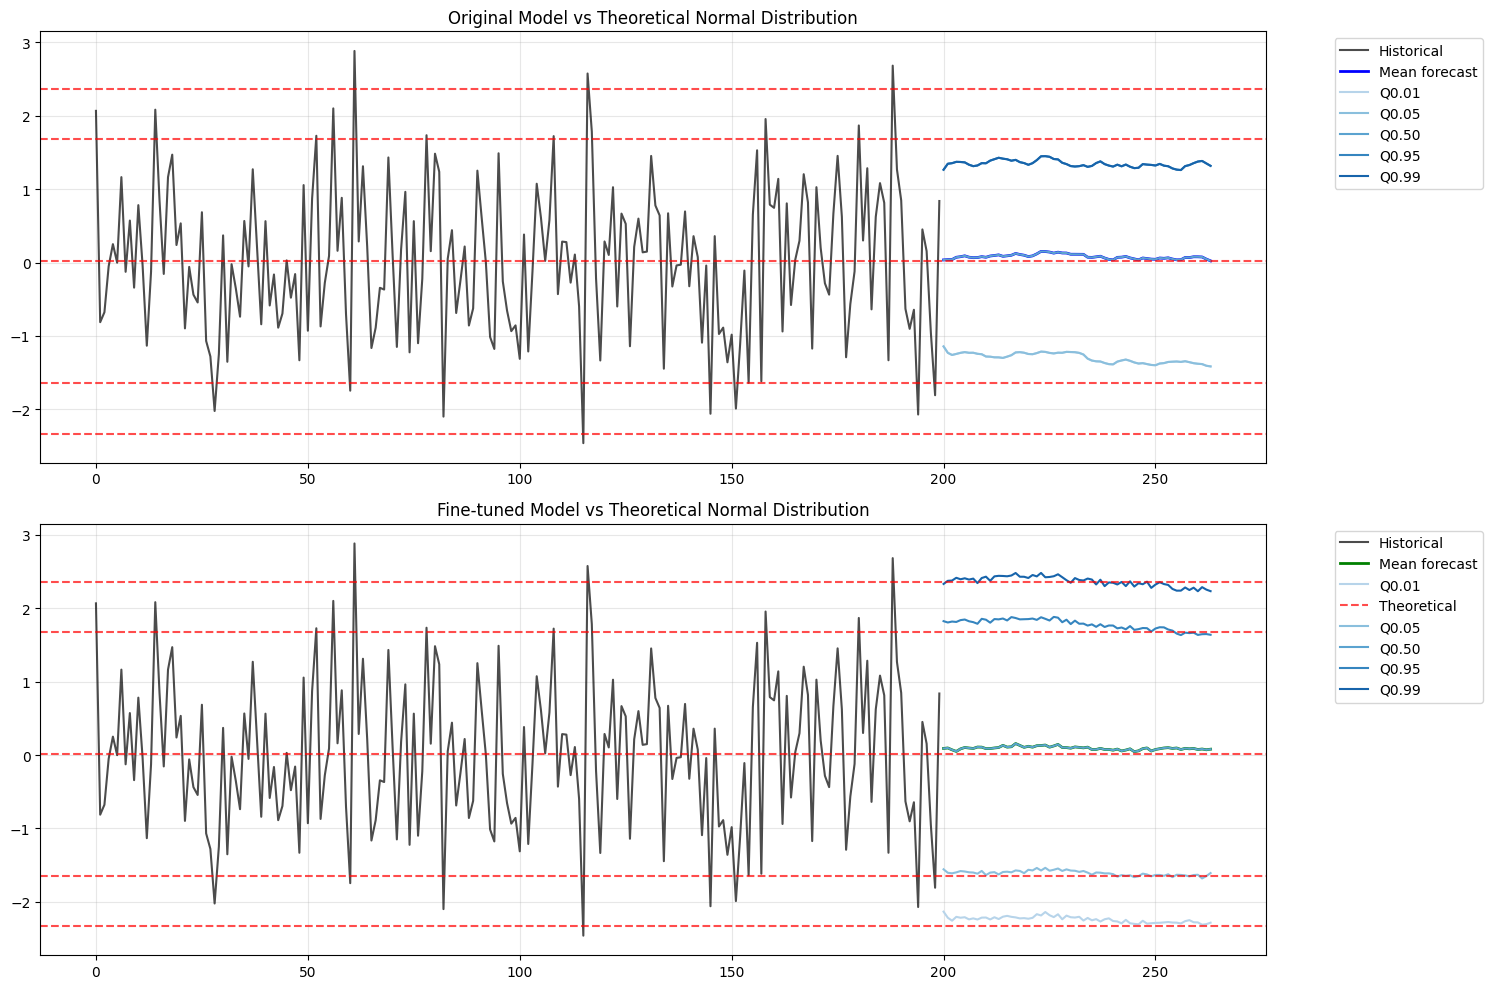

Quantile Level Comparison (last forecast step):
Quantile   Theoretical  Original     Fine-tuned  
--------------------------------------------------
0.01       -2.330       -1.415       -2.284      
0.05       -1.642       -1.415       -1.608      
0.50       0.018        0.023        0.080       
0.95       1.678        1.318        1.640       
0.99       2.365        1.318        2.234       


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get predictions from both models
preds_orig = predictor.predict(df, model=predictor.model_names()[0])
preds_new = predictor.predict(df, model=predictor.model_names()[1])

# Get historical data (convert MultiIndex to simple range for plotting)
history = df.iloc[-200:].reset_index()
forecast_steps = np.arange(len(history), len(history) + len(preds_orig))

# Calculate theoretical normal distribution quantiles
data_mean = df['target'].mean()
data_std = df['target'].std()
theoretical_quantiles = {str(q): stats.norm.ppf(q, loc=data_mean, scale=data_std)
                        for q in predictor.quantile_levels}

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Original model
ax1.plot(range(len(history)), history['target'], 'k-', label='Historical', alpha=0.7)
ax1.plot(forecast_steps, preds_orig['mean'], 'b-', label='Mean forecast', linewidth=2)

# Plot quantile bands and theoretical lines
colors = plt.cm.Blues(np.linspace(0.3, 0.8, len(predictor.quantile_levels)))
for i, q in enumerate(predictor.quantile_levels):
    q_str = str(q)
    ax1.plot(forecast_steps, preds_orig[q_str], color=colors[i], label=f'Q{q:.2f}')
    ax1.axhline(y=theoretical_quantiles[q_str], color='red', linestyle='--', alpha=0.7)

ax1.set_title('Original Model vs Theoretical Normal Distribution')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Fine-tuned model
ax2.plot(range(len(history)), history['target'], 'k-', label='Historical', alpha=0.7)
ax2.plot(forecast_steps, preds_new['mean'], 'g-', label='Mean forecast', linewidth=2)

for i, q in enumerate(predictor.quantile_levels):
    q_str = str(q)
    ax2.plot(forecast_steps, preds_new[q_str], color=colors[i], label=f'Q{q:.2f}')
    ax2.axhline(y=theoretical_quantiles[q_str], color='red', linestyle='--', alpha=0.7,
               label='Theoretical' if i == 0 else "")

ax2.set_title('Fine-tuned Model vs Theoretical Normal Distribution')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print quantile comparison
print("Quantile Level Comparison (last forecast step):")
print(f"{'Quantile':<10} {'Theoretical':<12} {'Original':<12} {'Fine-tuned':<12}")
print("-" * 50)
for q in predictor.quantile_levels:
    q_str = str(q)
    theoretical = theoretical_quantiles[q_str]
    orig_val = preds_orig[q_str].iloc[-1]
    new_val = preds_new[q_str].iloc[-1]
    print(f"{q:<10.2f} {theoretical:<12.3f} {orig_val:<12.3f} {new_val:<12.3f}")
